In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from astropy.io import fits
import os
import healpy as hp

import plotting
import auxil_ML as aux
import healpylib3 as hlib




In [2]:
def accuracy_score_loc(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)
accuracy_score = accuracy_score_loc

In [3]:
plotting.setup_figure_pars()

0

In [4]:
if 0:
    import importlib
    importlib.reload(plotting);
    importlib.reload(aux);
    importlib.reload(hlib);

In [5]:
def min_max_vs(dct, corr={}):
    vals = np.array([dct[key] - corr.get(key, 0.) for key in dct.keys()])
    return np.min(vals, axis=0), np.max(vals, axis=0)

def plot_mollview(fmap, title='', fig=None, vmin=None, vmax=None, **kwargs):
    hp.mollview(fmap, title=title, fig=fig, cbar=None, min=vmin, max=vmax) #cmap=r'afmhot_r'
    #plotting.add_mollview_colorbar(pix_map, label='', nticks=5, ticks=None, tick_labels=None)
    plotting.add_mollview_colorbar(fmap, vmin=vmin, vmax=vmax, **kwargs)
    dpar = 30
    dmer = 30
    grat = hp.graticule(dpar=dpar, dmer=dmer, ls=':')


In [8]:
cat = '3FGL'
folder = '../SOM'
cat_fn = '%s/%s_prob_catalog_2classes.csv' % (folder, cat)

cat_df = pd.read_csv(cat_fn, index_col=0)
labels = ['AGN', 'PSR', 'MIXED']
plots_folder = 'plots/Accuracies'
print(cat_df.columns)

Index(['GLON', 'GLAT', 'ln(Energy_Flux100)', 'ln(Unc_Energy_Flux100)',
       'ln(Signif_Curve)', 'ln(Variability_Index)', '500MeV_Index', 'HR12',
       'HR23', 'HR34', 'HR45', 'Category_3FGL', 'CLASS_3FGL', 'Pivot_Energy',
       'Spectrum_Type', 'ASSOC1', 'Flags_3FGL', 'AGN_BDT', 'AGN_BDT_STD',
       'PSR_BDT', 'PSR_BDT_STD', 'AGN_NN', 'AGN_NN_STD', 'PSR_NN',
       'PSR_NN_STD', 'AGN_RF', 'AGN_RF_STD', 'PSR_RF', 'PSR_RF_STD', 'AGN_LR',
       'AGN_LR_STD', 'PSR_LR', 'PSR_LR_STD', 'AGN_BDT_O', 'AGN_BDT_STD_O',
       'PSR_BDT_O', 'PSR_BDT_STD_O', 'AGN_NN_O', 'AGN_NN_STD_O', 'PSR_NN_O',
       'PSR_NN_STD_O', 'AGN_RF_O', 'AGN_RF_STD_O', 'PSR_RF_O', 'PSR_RF_STD_O',
       'AGN_LR_O', 'AGN_LR_STD_O', 'PSR_LR_O', 'PSR_LR_STD_O',
       'Missing_Values_Flag', 'Category_Prob'],
      dtype='object')


In [9]:
cat_df['Category_Prob']

Source_Name_3FGL
3FGL J0001.0+6314       AGN
3FGL J0001.2-0748       AGN
3FGL J0001.4+2120       AGN
3FGL J0002.2-4152       AGN
3FGL J0003.2-5246       AGN
                      ...  
3FGL J2021.0+4031e    MIXED
3FGL J2028.6+4110e    MIXED
3FGL J1513.9-5908     MIXED
3FGL J0121.8-3917       AGN
3FGL J1655.1-3954       AGN
Name: Category_Prob, Length: 3034, dtype: object

In [10]:
add_os = True
if add_os:
    weight_str = 'oversample'
    if 0:
        #weight_str = 'weighted'
        fn = '../ML_3FGL_paper_extra/data/python files/catas/%s_unassoc_%s.csv' % (cat, weight_str)
        print(fn)
        pcat_os = pd.read_csv(fn, index_col='Source_Name_%s' % cat)
        print(pcat_os.columns)
        sin_glat_os = np.abs(np.sin(np.deg2rad(pcat_os['GLAT_%s' % cat])))
        #glat = np.abs(cat_df['GLAT'])
        #pcat_os = pd.read_csv(fn)
    estr = '_%s' % weight_str
else:
    estr = ''

In [11]:
sin_glat = np.abs(np.sin(np.deg2rad(cat_df['GLAT'])))
glat = np.abs(cat_df['GLAT'])

In [12]:
nbins = 7
sin_bins = np.linspace(0, 1, nbins + 1)
sin_bins_c = (sin_bins[1:] + sin_bins[:-1]) / 2
print(sin_bins_c)

[0.07142857 0.21428571 0.35714286 0.5        0.64285714 0.78571429
 0.92857143]


In [13]:
masks = {}
masks['AGN & PSR'] = (cat_df['Category_%s' % cat] == 'AGN') | (cat_df['Category_%s' % cat] == 'PSR')
masks['AGN'] = (cat_df['Category_%s' % cat] == 'AGN')
masks['PSR'] = (cat_df['Category_%s' % cat] == 'PSR')
masks['PSR any algorithm'] = masks['PSR']
masks['UNAS'] = (cat_df['Category_%s' % cat] == 'UNAS')
masks['ASSOC'] = (cat_df['Category_%s' % cat] != 'UNAS')


In [14]:
res_recall = {}
res_prec = {}
nsrc_recall = {}
nsrc_prec = {}
for key in masks.keys():
    res_recall[key] = np.zeros(nbins)
    res_prec[key] = np.zeros(nbins)
    nsrc_recall[key] = np.zeros(nbins)
    nsrc_prec[key] = np.zeros(nbins)

if add_os:
    res_recall_os = {}
    res_prec_os = {}
    nsrc_recall_os = {}
    nsrc_prec_os = {}
    for key in masks.keys():
        res_recall_os[key] = np.zeros(nbins)
        res_prec_os[key] = np.zeros(nbins)
        nsrc_recall_os[key] = np.zeros(nbins)
        nsrc_prec_os[key] = np.zeros(nbins)
    
#alg = 'All algs'
algs0 = ['NN', 'LR', 'RF', 'BDT']
algs = ['All algs', 'NN', 'LR', 'RF', 'BDT'][:1]
plot_keys = ['PSR', 'PSR any algorithm']
save_plots = False

masks_prec = {}
for alg in algs0:
    masks_prec['PSR any algorithm'] = (cat_df['PSR_%s' % alg] > 0.5) | masks_prec.get('PSR any algorithm', False)

#print(np.sum(masks_prec['PSR any algorithm']))
#print(np.sum(cat_df['Category_Prob'] == 'PSR'))

markers = ['s', '>', 'D', 'v', 'o', '*']
mss = [6, 6, 6, 6, 6, 9]
j = 0
for alg in algs:
    if alg == 'All algs':
        masks_prec['AGN & PSR'] = (cat_df['Category_Prob'] == 'AGN') | (cat_df['Category_Prob'] == 'PSR')
        masks_prec['AGN'] = (cat_df['Category_Prob'] == 'AGN')
        masks_prec['PSR'] = (cat_df['Category_Prob'] == 'PSR')
        if add_os and key.find('any algorithm') == -1:
            prob_kw = 'Category_Prob_O'
            masks_prec['AGN & PSR O'] = (cat_df[prob_kw] == 'AGN') | (cat_df[prob_kw] == 'PSR')
            masks_prec['AGN O'] = (cat_df[prob_kw] == 'AGN')
            masks_prec['PSR O'] = (cat_df[prob_kw] == 'PSR')
            
    else:
        masks_prec['AGN & PSR'] = (cat_df['AGN_%s' % alg] > 0.5) | (cat_df['PSR_%s' % alg] > 0.5)
        masks_prec['AGN'] = (cat_df['AGN_%s' % alg] > 0.5)
        masks_prec['PSR'] = (cat_df['PSR_%s' % alg] > 0.5)
    #plot_keys = masks_prec.keys()
    for i in range(nbins):
        for key in plot_keys:
            # take all true members of a class
            bin_mask = (sin_glat > sin_bins[i]) & (sin_glat <= sin_bins[i + 1]) & masks[key]
            y_true = cat_df['Category_%s' % cat][bin_mask]
            if alg == 'All algs':
                y_pred = cat_df['Category_Prob'][bin_mask]
                if key == 'PSR any algorithm':
                    mixed_mask = (y_pred == 'MIXED')
                    y_pred[mixed_mask] = 'PSR'
                if add_os and key.find('any algorithm') == -1:
                    y_pred_os = cat_df['Category_Prob_O'][bin_mask]
            else:
                y_pred = y_true.copy()
                y_pred[:] = 'PSR'
                agn_mask = cat_df['AGN_%s' % alg][bin_mask] > 0.5
                y_pred[agn_mask] = 'AGN'
            # the fraction of true members that was correctly recovered
            res_recall[key][i] = accuracy_score(y_true, y_pred)
            nsrc_recall[key][i] = np.sum(bin_mask)
            if add_os and key.find('any algorithm') == -1:
                res_recall_os[key][i] = accuracy_score(y_true, y_pred_os)
                nsrc_recall_os[key][i] = np.sum(bin_mask)
            
            # take all sources predicted to belong to a class (among AGNs and PSRs)
            bin_mask = (sin_glat > sin_bins[i]) & (sin_glat <= sin_bins[i + 1]) & masks_prec[key] & masks['AGN & PSR']
            y_true = cat_df['Category_%s' % cat][bin_mask]
            if add_os and key.find('any algorithm') == -1:
                bin_mask_os = (sin_glat > sin_bins[i]) & (sin_glat <= sin_bins[i + 1]) & masks_prec[key + ' O'] & masks['AGN & PSR']
                y_true_os = cat_df['Category_%s' % cat][bin_mask_os]
            if alg == 'All algs':
                y_pred = cat_df['Category_Prob'][bin_mask]
                if add_os and key.find('any algorithm') == -1:
                    y_pred_os = cat_df['Category_Prob_O'][bin_mask_os]
                    
            else:
                y_pred = y_true.copy()
                y_pred[:] = 'PSR'
                agn_mask = cat_df['AGN_%s' % alg][bin_mask] > 0.5
                y_pred[agn_mask] = 'AGN'
            # calculate the fraction of correctly predicted ones
            res_prec[key][i] = accuracy_score(y_true, y_pred)
            nsrc_prec[key][i] = np.sum(bin_mask)
            if add_os:
                res_prec_os[key][i] = accuracy_score(y_true_os, y_pred_os)
                nsrc_prec_os[key][i] = np.sum(bin_mask_os)
                
            
    lss = ['-', '-.', '--', ':']
    pyplot.figure()
    for i, key in enumerate(plot_keys):
        if 0:
            print(key)
            print(res_recall[key])
            print(res_prec[key])
        if key.find('any algorithm') != -1:
            label0 = 'Any algorithm'
        else:
            label0 = 'All algorithms'
        pyplot.plot(sin_bins_c, res_prec[key], ls='-', marker=markers[j], ms=mss[j],
                    label=label0 + ' precision')
        j += 1
        pyplot.plot(sin_bins_c, res_recall[key], ls='--', marker=markers[j], ms=mss[j],
                    label=label0 + ' recall')
        j += 1
        if add_os and key.find('any algorithm') == -1:
            prec_os = res_prec_os[key]
            recall_os = res_recall_os[key]
            
    if add_os:
        label0 = 'All algorithms'
        pyplot.plot(sin_bins_c, prec_os, ls='-', marker=markers[j], ms=mss[j],
                    label=label0 + ' precision (oversample)')
        j += 1
        pyplot.plot(sin_bins_c, recall_os, ls='--', marker=markers[j], ms=mss[j],
                    label=label0 + ' recall (oversample)')
        j += 1
        
    pyplot.xlabel('abs(sin(GLAT))')
    pyplot.ylabel('Precision or Recall')
    if alg != 'All algs':
        pyplot.title('%s, %s' % (cat, alg))
    else:
        pyplot.title('%s, %s' % (cat, 'PSR'))
    pyplot.legend(labelspacing=0.2)
    pyplot.ylim(0.3, 1.5)

    if save_plots:
        fn = '%s/%s_%s_precision_recall.pdf' % (plots_folder, alg.replace(' ', '_'), cat)
        if add_os:
            fn = '%s/%s_%s_precision_recall_oversample.pdf' % (plots_folder, alg.replace(' ', '_'), cat)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)
        if 1:
            command = 'cp %s ../ML_3FGL_paper/plots' % fn
            print(command)
            os.system(command)

    pyplot.figure()
    for i, key in enumerate(plot_keys):
        pyplot.semilogy(sin_bins_c, nsrc_recall[key], ls=lss[2 * i], label=key + ' recall')
        pyplot.semilogy(sin_bins_c, nsrc_prec[key], ls=lss[2 * i + 1], label=key + ' precsision')
    pyplot.xlabel('abs(sin(GLAT))')
    pyplot.ylabel('# of sources')
    pyplot.title('%s' % (cat))
    pyplot.legend()

    if save_plots:
        fn = '%s/source_counts_%s_%s.pdf' % (plots_folder, alg, cat)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)


KeyError: 'Category_Prob_O'

In [13]:
# GLAT distribution
nbins = 18
sin_bins_unif = np.linspace(0, 1, nbins+1)
sin_bins_unif_c = (sin_bins_unif[1:] + sin_bins_unif[:-1]) / 2.
lat_bins_unif = np.linspace(0, 90, nbins+1)
lat_bins_unif_c = (lat_bins_unif[1:] + lat_bins_unif[:-1]) / 2.
unas_mask = cat_df['Category_%s' % cat] == 'UNAS'

In [14]:
sin_bins_c

array([0.07142857, 0.21428571, 0.35714286, 0.5       , 0.64285714,
       0.78571429, 0.92857143])

In [15]:
pcat_SP = pd.read_csv('data/FGL3_results.csv', index_col='Source_Name')
pcat_SP.index = ['3FGL %s' %name.strip() for name in pcat_SP.index]
unass_lat_SP = {}
algs0_SP = ['RF', 'LR']
unas_mask_SP = pcat_SP['CLASS1'].copy()
unas_mask_SP[:] = [type(pcat_SP['CLASS1'].iloc[i]) != str for i in range(len(unas_mask_SP))]
sin_glat_SP = np.abs(np.sin(np.deg2rad(pcat_SP['GLAT'])))
glat_SP = np.abs(pcat_SP['GLAT'])
glon_SP = pcat_SP['GLON'] - 360 * (pcat_SP['GLON'] // 180)

In [16]:
#plotting.setup_figure_pars()
#print(pyplot.rcParams['figure.subplot.bottom'])

ValueError: zero-size array to reduction operation minimum which has no identity

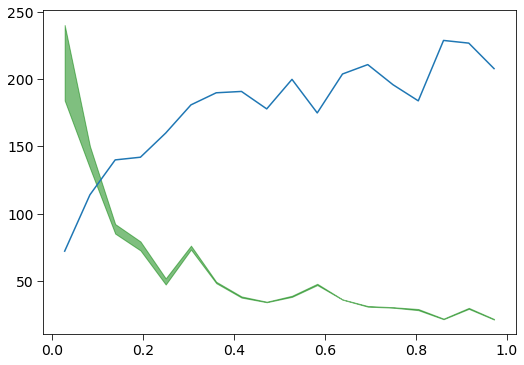

In [17]:
SP_colors = ['violet', 'brown']
use_sin_glat = 1
#plotting.setup_figure_pars()
#print(pyplot.rcParams['figure.subplot.left'])
#pyplot.rcParams['figure.subplot.bottom'] = 0.15
unass_lat_tot = np.histogram(sin_glat[unas_mask], bins=sin_bins_unif)[0]
for pop in ['AGN', 'PSR']:
    ass_lat = np.histogram(sin_glat[masks[pop]], bins=sin_bins_unif)[0]
    unass_lat = {}
    if add_os:
        unass_lat_os = {}
    unass_lat_av = np.zeros(nbins)
    for alg in algs0:
        if use_sin_glat:
            unass_lat[alg] = np.histogram(sin_glat[unas_mask], bins=sin_bins_unif, 
                                              weights=cat_df['%s_%s' % (pop, alg)][unas_mask])[0]
            #if add_os:
            #    unass_lat_os[alg] = np.histogram(sin_glat_os, bins=sin_bins_unif, 
            #                                  weights=pcat_os['%s_%s' % (pop, alg)])[0]

        else:
            unass_lat[alg] = np.histogram(glat[unas_mask], bins=lat_bins_unif, 
                                              weights=cat_df['%s_%s' % (pop, alg)][unas_mask])[0]
            
        unass_lat_av += unass_lat[alg] / len(algs0)
    
    if cat == '3FGL':
        for alg in algs0_SP:
            if pop == 'PSR':
                weights = pcat_SP['%s_P' % alg][unas_mask_SP]
            elif pop == 'AGN':
                weights = 1 - pcat_SP['%s_P' % alg][unas_mask_SP]
            if use_sin_glat:
                unass_lat_SP[alg] = np.histogram(sin_glat_SP[unas_mask_SP], bins=sin_bins_unif, 
                                              weights=weights)[0]
            else:
                unass_lat_SP[alg] = np.histogram(glat_SP[unas_mask_SP], bins=lat_bins_unif, 
                                              weights=weights)[0]
                
            
    minvs, maxvs = min_max_vs(unass_lat)
    if use_sin_glat:
        xs = sin_bins_unif_c
    else:
        xs = lat_bins_unif_c
    fig = pyplot.figure()
    pyplot.plot(xs, ass_lat, label='Assoc')
    pyplot.fill_between(xs, minvs, maxvs, color='green', alpha=0.5, label='Unassoc')
    if add_os:
        minvs, maxvs = min_max_vs(unass_lat_os)
        pyplot.fill_between(xs, minvs, maxvs, color='darkred', alpha=0.5, label='Unassoc oversample')
    if 0:
        for alg in algs0:
            pyplot.plot(xs, unass_lat[alg], ls='--', label=alg)
    
    pyplot.fill_between(xs, ass_lat + minvs, ass_lat + maxvs, color='gray', alpha=0.5, 
                        label='Assoc + Unassoc')
    mean = np.mean(ass_lat + unass_lat_av) * np.ones(nbins)
    pyplot.plot(xs, ass_lat + unass_lat_av, label='Assoc + Unassoc av.')
    #pyplot.errorbar(xs, ass_lat + unass_lat_av, np.sqrt(mean), ls='', marker='s', label='Assoc + Unassoc av.')
    pyplot.plot(xs, unass_lat_tot, ls='-.', color='r', label='Unassoc total')
    

    if pop == 'AGN':
        pyplot.plot(xs, mean, ls=':', label='Mean')
    if cat == '3FGL':
        for i, alg in enumerate(algs0_SP):
            pyplot.plot(xs, unass_lat_SP[alg], ls='--', c=SP_colors[i], 
                        label='%s (SP16)' % alg)


    pyplot.title('%s %s' %(cat, pop))
    pyplot.legend(ncol=2)
    pyplot.grid()
    if use_sin_glat:
        pyplot.xlabel('abs(sin(GLAT))')
        pyplot.xlim(0, 1)
        #x_ticks = fig.axes[0].get_xticks()
        #x_ticks_new = np.around(np.rad2deg(np.arcsin(x_ticks)))
        #fig.axes[0].set_xticks(x_ticks_new)
    else:
        pyplot.xlabel('abs(GLAT)')
        pyplot.xlim(0, 90)
        
    pyplot.ylabel('Number of sources')
    if cat == '3FGL':
        pyplot.ylim(0, 300)
    elif cat == '4FGL':
        pyplot.ylim(0, 400)

    if save_plots:
        fn = '%s/lat_profile_%s_%s%s.pdf' % (plots_folder, pop, cat, estr)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)
        if not add_os:
            cmd = 'cp %s ../ML_3FGL_paper/plots' % fn
            print(cmd)
            os.system(cmd)


In [18]:
x_ticks = fig.axes[0].get_xticks()
x_ticks_new = np.around(np.rad2deg(np.arcsin(x_ticks)))
print(x_ticks, x_ticks_new)

[-0.2  0.   0.2  0.4  0.6  0.8  1.   1.2] [-12.   0.  12.  24.  37.  53.  nan  nan]


/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arcsin
  


save figure to file: plots/Accuracies/lon_profile_AGN_4FGL.pdf
cp plots/Accuracies/lon_profile_AGN_4FGL.pdf ../ML_3FGL_paper/plots
save figure to file: plots/Accuracies/lon_profile_PSR_4FGL.pdf
cp plots/Accuracies/lon_profile_PSR_4FGL.pdf ../ML_3FGL_paper/plots


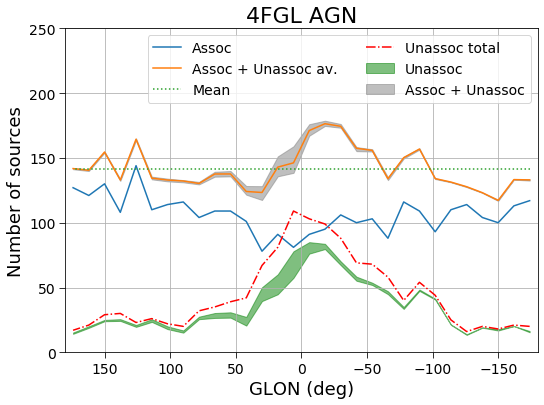

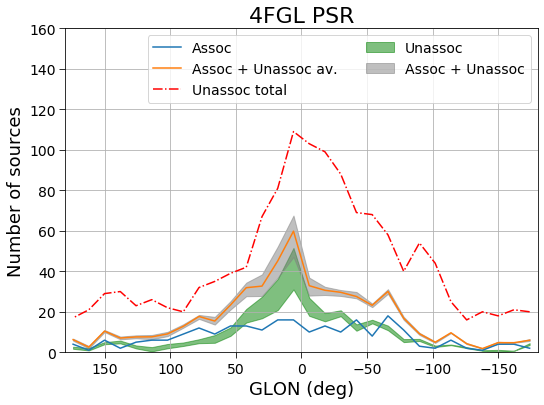

In [19]:
nbins_lon = 30
glon_bins = np.linspace(-180, 180, nbins_lon + 1)
glon_bins_c = (glon_bins[1:] + glon_bins[:-1]) / 2.
# make the range from -180 to 180
glon = cat_df['GLON'] - 360. * (cat_df['GLON'] // 180.)

unass_lon_tot = np.histogram(glon[unas_mask], bins=glon_bins)[0]
for pop in ['AGN', 'PSR']:
    ass_lon = np.histogram(glon[masks[pop]], bins=glon_bins)[0]
    unass_lon = {}
    unass_lon_SP = {}
    unass_lon_av = np.zeros(nbins_lon)
    for alg in algs0:
        unass_lon[alg] = np.histogram(glon[unas_mask], bins=glon_bins, 
                                          weights=cat_df['%s_%s' % (pop, alg)][unas_mask])[0]
        unass_lon_av += unass_lon[alg] / len(algs0)

        
    if cat == '3FGL':
        for alg in algs0_SP:
            if pop == 'PSR':
                weights = pcat_SP['%s_P' % alg][unas_mask_SP]
            elif pop == 'AGN':
                weights = 1 - pcat_SP['%s_P' % alg][unas_mask_SP]
            unass_lon_SP[alg] = np.histogram(glon_SP[unas_mask_SP], bins=glon_bins, 
                                              weights=weights)[0]

    
    minvs, maxvs = min_max_vs(unass_lon)
    xs = glon_bins_c
    pyplot.figure()
    pyplot.plot(xs, ass_lon, label='Assoc')
    pyplot.plot(xs, ass_lon + unass_lon_av, label='Assoc + Unassoc av.')
    if pop == 'AGN':
        mean = np.mean(ass_lon + unass_lon_av) * np.ones(nbins_lon)
        pyplot.plot(xs, mean, ls=':', label='Mean')
    pyplot.plot(xs, unass_lon_tot, ls='-.', color='r', label='Unassoc total')
    pyplot.fill_between(xs, minvs, maxvs, color='green', alpha=0.5, label='Unassoc')
    pyplot.fill_between(xs, ass_lon + minvs, ass_lon + maxvs, color='gray', alpha=0.5, 
                        label='Assoc + Unassoc')

    if 0:
        for alg in algs0:
            pyplot.plot(xs, unass_lon[alg], ls='--', label=alg)
    
    
    if cat == '3FGL':
        for i, alg in enumerate(algs0_SP):
            pyplot.plot(xs, unass_lon_SP[alg], ls='--', c=SP_colors[i], 
                        label='%s (SP16)' % alg)

    pyplot.title('%s %s' % (cat, pop))
    pyplot.legend(ncol=2)
    pyplot.grid()
    pyplot.xlabel('GLON (deg)')
    pyplot.ylabel('Number of sources')
    pyplot.xlim(180, -180)
    if cat == '4FGL':
        if pop == 'AGN':
            pyplot.ylim(0, 250)
        else:
            pyplot.ylim(0, 160)
    else:
        if pop == 'AGN':
            pyplot.ylim(0, 180)
        else:
            pyplot.ylim(0, 100)
        
            
    if save_plots:
        fn = '%s/lon_profile_%s_%s.pdf' % (plots_folder, pop, cat)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)
        cmd = 'cp %s ../ML_3FGL_paper/plots' % fn
        print(cmd)
        os.system(cmd)


In [ ]:
nside = 64
npix = hp.nside2npix(nside)


In [ ]:
# calculate unass pixels
def mask2pixels(mask):
    phi = np.deg2rad(cat_df['GLON'][mask])
    theta = np.pi/2 - np.deg2rad(cat_df['GLAT'][mask])
    return list(hp.ang2pix(nside, theta, phi))

pix_dict = {}
for pop in ['AGN', 'PSR', 'UNAS']:
    pix_dict[pop] = mask2pixels(masks[pop])


In [ ]:
alg = 'NN'
hpm_dict_ass = {}
hpm_dict_unass = {}
sigma = np.radians(10.)
for pop in ['AGN', 'PSR']:
    # associated sources
    hpm_dict_ass[pop] = np.zeros(npix)
    for i, ind in enumerate(pix_dict[pop]):
        hpm_dict_ass[pop][ind] += 1
    hpm_dict_ass[pop + '_sm'] = hp.smoothing(hpm_dict_ass[pop], sigma=sigma)
        
    # probabilities for unassociated sources
    probs = cat_df['%s_%s' % (pop, alg)][masks['UNAS']]
    hpm_dict_unass[pop] = np.zeros(npix)
    for i, ind in enumerate(pix_dict['UNAS']):
        hpm_dict_unass[pop][ind] += probs[i]
    hpm_dict_unass[pop + '_sm'] = hp.smoothing(hpm_dict_unass[pop], sigma=sigma)

In [ ]:
for pop in ['AGN', 'PSR']:
    hp.mollview(hpm_dict_ass[pop], title='%s assoc' % pop)

In [ ]:
for pop in ['AGN', 'PSR']:
    hp.mollview(hpm_dict_unass[pop], title='%s unassoc' % pop)

In [ ]:
plot = plot_mollview # hp.mollview
nfig = 1
for pop in ['AGN', 'PSR']:
    pyplot.figure(nfig)
    plot(hpm_dict_ass[pop + '_sm'], title='%s assoc smooth' % pop, fig=nfig)
    nfig += 1
    pyplot.figure(nfig)
    plot(hpm_dict_unass[pop + '_sm'], title='%s unassoc smooth' % pop, fig=nfig)
    nfig += 1
    fig = pyplot.figure(nfig)
    hmap = hpm_dict_unass[pop + '_sm'] + hpm_dict_ass[pop + '_sm']
    plot(hmap, title='%s assoc + unassoc smooth' % pop, fig=nfig)
    fig.savefig('plots/maps/%s_assoc_unassoc.pdf' % pop)
    nfig += 1

In [ ]:
# back of the envelop check of flux from pulsars for GC excess
Om = 4. * np.pi / npix # pixel area
erg2gev = 1.e3 / 1.6
sigma = np.radians(2.)
vmin = 0
vmax = 1.e-5
if cat == '3FGL':
    fn_cat = '../PS_comparison/gll_psc_v16.fit' # the last release of 3FGL
else:
    fn_cat = '../PS_comparison/gll_psc_v22.fit' # 4FGL release from 27 May 2020
fn_pcat = 'data/%s_prob_catalog.csv' % cat
hdu_cat = fits.open(fn_cat)
eflux = 'Energy_Flux100'

In [ ]:
# exposure map
fn = 'data/expcube_P8_P302_Source_z100_w009_w478_P8R2_SOURCE_V6_healpix_o7_24bins.fits'
exp = fits.open(fn)
exp_data = np.array(exp[1].data.field('Spectra')).T

In [ ]:
exp_plot = hp.ud_grade(exp_data[10], nside_out=64)
#plot(exp_plot, title='Exposure')
pop = 'AGN'
plot(hmap, title='%s assoc + unassoc smooth' % pop)
hmap = hpm_dict_unass[pop + '_sm'] + hpm_dict_ass[pop + '_sm']
plot(hmap / exp_plot, title='%s assoc + unassoc smooth / exp' % pop)


In [ ]:
fgl_df0 = aux.hdu2df(hdu_cat[1], index_name='Source_Name') # transform hdu table to dataframe
fgl_df = fgl_df0.loc[cat_df.index] # remove sources with missing values

In [ ]:
def make_hmap(npix, df, prob_df, mask, name, pop='PSR', method='assoc'):
    masked_df = df[mask]
    if method == 'assoc':
        weights = pd.DataFrame(data=np.ones(len(masked_df)), index=masked_df.index)
    else:
        weights=cat_df['%s_%s' % (pop, method)][mask]
    phi = np.deg2rad(df['GLON'][mask])
    theta = np.pi/2 - np.deg2rad(df['GLAT'][mask])
    pixels = hp.ang2pix(nside, theta, phi)
    hmap = np.zeros(npix)
    for ind in masked_df.index:
        hmap[pixels.loc[ind]] += fgl_df[name][ind] * weights.loc[ind]
    return hmap

In [ ]:
# create a Eflux map for associated sources
name = 'Energy_Flux100'
hmap_eflux_ass_dict = {}

for pop in ['PSR', 'AGN']:
    mask = masks[pop]
    hmap = make_hmap(npix, fgl_df, cat_df, mask, name, pop=pop, method='assoc') * erg2gev / Om
    hmap_eflux_ass_dict[pop] = hmap
    hmap_eflux_ass_dict[pop + '_sm'] = hp.smoothing(hmap, sigma=sigma)

In [ ]:
for nfig, pop in enumerate(['PSR', 'AGN']):
    fig = pyplot.figure(nfig)
    plot_mollview(hmap_eflux_ass_dict[pop + '_sm'], title='%s Eflux assoc' % pop, fig=nfig,
                  vmin=vmin, vmax=vmax)

In [ ]:
# create a Eflux map for unassociated sources
name = 'Energy_Flux100'
hmap_eflux_unass_dict = {}

for pop in ['PSR', 'AGN']:
    mask = masks['UNAS']
    hmap = make_hmap(npix, fgl_df, cat_df, mask, name, pop=pop, method='NN') * erg2gev / Om
    hmap_eflux_unass_dict[pop] = hmap
    hmap_eflux_unass_dict[pop + '_sm'] = hp.smoothing(hmap, sigma=sigma)

In [ ]:
for nfig, pop in enumerate(['PSR', 'AGN']):
    fig = pyplot.figure(nfig)
    plot_mollview(hmap_eflux_unass_dict[pop + '_sm'], title='%s Eflux unassoc' % pop, fig=nfig,
                  vmin=vmin, vmax=vmax)

In [ ]:
for nfig, pop in enumerate(['PSR', 'AGN']):
    fig = pyplot.figure(nfig)
    hmap = hmap_eflux_ass_dict[pop + '_sm'] + hmap_eflux_unass_dict[pop + '_sm']
    plot_mollview(hmap, title='%s Eflux assoc + unassoc' % pop, fig=nfig, 
                  vmin=vmin, vmax=vmax)

In [ ]:
nL = 9
dL = 3.
Lbins = np.linspace(-nL * dL / 2., nL * dL / 2., nL + 1)
Lc = (Lbins[1:] + Lbins[:-1]) / 2
nB = 21
dB = 3.
Bbins = np.linspace(-nB * dB / 2., nB * dB / 2., nB + 1)
Bc = (Bbins[1:] + Bbins[:-1]) / 2

In [ ]:
inds_dict = hlib.lb_profiles_hinds_dict(nside, Bbins, Lbins, mask=None)

In [ ]:
fpix = hmap_eflux_unass_dict['PSR']
profiles = hlib.fpix_lb_profiles(fpix, inds_dict, nB, nL, std=0)

In [ ]:
# latitude profiles
fig = pyplot.figure()
for i in range(nL):
    ys = profiles[:, i]
    pyplot.plot(Bc, ys, label='L = %i' % Lc[i])
pyplot.legend()
fig.axes[0].ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
pyplot.grid()

In [ ]:
# longitude profiles
fig = pyplot.figure()
for i in range(8, 13):
    ys = profiles[i]
    pyplot.plot(Lc, ys, label='B = %i' % Bc[i])
fig.axes[0].ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
pyplot.legend()
pyplot.grid()

In [ ]:
thres = 0.5
ang = 20
bl_mask = (cat_df['GLON'] < ang) | (cat_df['GLON'] > 360 - ang)
print(np.sum(bl_mask))
bl_mask &= (cat_df['GLAT'] < ang) & (cat_df['GLAT'] > - ang)
print(np.sum(bl_mask))
bl_mask &= masks['UNAS']
print('Number of unassociated sources: %i' % np.sum(bl_mask))
bl_mask_thres = bl_mask & (cat_df['PSR_NN'] > thres)
print('%i sources above threshold %.1f' % (np.sum(bl_mask_thres), thres))
print('Sum of probabilities: %.1f' % np.sum(cat_df['PSR_NN'][bl_mask]))

In [ ]:
min_psr_eflux = np.min(fgl_df[eflux][bl_mask])

In [ ]:
kpc2sm = 3.e21 # kpc in cm
def eflux2elum(eflux, dist):
    dist_cm = dist * kpc2sm
    return 4. * np.pi * eflux * dist_cm**2

In [ ]:
Elums = eflux2elum(fgl_df[eflux][bl_mask], 8.5)

In [ ]:
pyplot.hist(np.log10(Elums), bins=20)

In [ ]:
pcat_SP

In [ ]:
vmin = -15.
vmax = 0.
for alg in ['RF', 'LR']:
    for pop in ['UNAS', 'AGN & PSR']:
        pyplot.figure()
        print(pop)
        vals_SP = 2 * np.log(pcat_SP['%s_P' % alg][masks[pop]])
        vals_we = 2 * np.log(cat_df['PSR_%s' % alg][masks[pop]])
        mask = (vals_SP < vmax) & (vals_SP > vmin) & (vals_we < vmax) & (vals_we > vmin)
        print(sum(mask), len(mask))
        print('SP:', np.sum(pcat_SP['%s_P' % alg][masks[pop] & mask]))
        print('we:', np.sum(cat_df['PSR_%s' % alg][masks[pop] & mask]))
        hst = pyplot.hist(vals_SP[mask], bins=np.linspace(vmin, vmax, 51), alpha = 0.5, 
                          label=pop + ' SP')
        hst = pyplot.hist(vals_we[mask], bins=np.linspace(vmin, vmax, 51), alpha = 0.5, 
                          label=pop + ' we')
        pyplot.legend()
        pyplot.title(alg + ' PSR')

In [ ]:
masks.keys()